In [3]:
import numpy as np
import scipy.integrate as integrate

import sys

import csv
#import pickle
import dill as pickle # use to save unnamed functions
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rc_file
rc_file('../matplotlibrc')

In [5]:
%reload_ext autoreload
%autoreload 2

sys.path.append('..')
from common import *

### SNRcat: convert html to csv
- download [this](http://snrcat.physics.umanitoba.ca/SNRdownload.php?&table=OBS) to `SNRcat20220619-OBS.csv`
- download [this](http://snrcat.physics.umanitoba.ca/SNRdownload.php?&table=SNR) to `SNRcat20220619-SNR.csv`

In [8]:
# removed first 2 lines of the files
reader = csv.reader(open('SNRcat20220619-SNR.csv', 'r'), delimiter=';')
next(reader)
next(reader)
writer = csv.writer(open('SNRcat20220619-SNR_dehead.csv', 'w'), delimiter=';')
writer.writerows(reader)

In [10]:
# removed first 2 lines of the files
reader = csv.reader(open('SNRcat20220619-OBS.csv', 'r'), delimiter=';')
next(reader)
next(reader)
writer = csv.writer(open('SNRcat20220619-OBS_dehead.csv', 'w'), delimiter=';')
writer.writerows(reader)

### Valid SNR from SNRcat
require SNR to have distance and age information

In [11]:
snr_list = []
snr_valid_list = []

with open('SNRcat20220619-SNR_dehead.csv', 'r') as csvf:
    csv_reader = csv.DictReader(csvf, delimiter=';')
    for i, row in enumerate(csv_reader):
        # must have dist, age min & max
        d_min = row['distance_min (kpc)']
        d_max = row['distance_max (kpc)']
        tn_min = row['age_min (yr)']
        tn_max = row['age_max (yr)']
        
        if row['G'] == 'G358.1+00.1':
            row['G'] = 'G358.1+01.0' # error in SNRcat
        
        valid = True
        if d_min=='' or d_max=='':
            valid = False
            d = None
        else:
            d = np.sqrt( float(d_min) * float(d_max) ) # geometric average
        if tn_min=='' or tn_max=='':
            valid = False
            tn = None
        else:
            tn = np.sqrt( float(tn_min) * float(tn_max) ) # geometric average
            #tn = float(tn_max) # geometric average
        
        snr = SNR(ID=row['G'],
                  name_alt=row['id_alt'],
                  snr_type=row['type'],
                  l=float(row['G'][1:6]),
                  b=float(row['G'][6:11]),
                  size=float(row['size_coarse (arcmin)']),
                  d=d,
                  tn=tn,
                  snrcat_dict=row )
        snr_list.append(snr)
        if valid:
            snr_valid_list.append(snr)
        print('\r%d: %s' % (i, snr.ID), end='', flush=True)

382: G359.9-00.0

### Valid SNR from Green's catalog
require SNR to have flux information
copy [this page](https://www.mrao.cam.ac.uk/surveys/snrs/snrs.data.html) to `Green.txt`

In [13]:
snr_valid_SG_list = []
varied_str = ''
cant_find_str = ''

with open('Green.txt') as f:
    lines = f.readlines()
    for i, line in enumerate(lines[4:]):
        line_strs = list(filter(None,line.split(' ')))
        green_dict = {}
        green_dict['ID'] = GID(line_strs[0], line_strs[1])
        green_dict['name_oth'] = '' if len(line_strs)<=11 else ' '.join(line_strs[11:]).replace('\n', '')
        green_dict['size_str'] = line_strs[7]
        green_dict['type'] = line_strs[8]
        green_dict['Snu1GHz'] = line_strs[9]
        green_dict['spec_ind'] = line_strs[10].replace('\n', '')
        
        snr       = get_snr(green_dict['ID'], snr_list)
        snr_valid = get_snr(green_dict['ID'], snr_valid_list)
        
        if snr is None:
            print('X', end='')
            cant_find_str += green_dict['ID'] + ' '
            continue
        if snr_valid is None:
            print('_', end='')
            continue
        
        Snu1GHz_str = green_dict['Snu1GHz'].replace('?','').replace('>','')
        if Snu1GHz_str == '':
            continue
        snr.Snu1GHz = float(Snu1GHz_str)
        
        si_str = green_dict['spec_ind'].replace('?','')
        if si_str == '':
            continue
        try:
            snr.si = float(si_str)
        except ValueError:
            snr.si = si_str
            varied_str += green_dict['ID']+' '+green_dict['spec_ind']+' '+green_dict['name_oth']+'\n'
        
        snr.green_dict = green_dict
            
        snr_valid_SG_list.append(snr)
        print('O', end='')
        
    if cant_find_str == '':
        cant_find_str = 'None.'
    print('\ncan\'t find: '+cant_find_str)
    print(varied_str)

O_O__O___________O____O__O_________O____________OO___O____O_OO___O_O_O_O_O__O___O___O_OOO__OO_O___O__OOOOOO__O___OOO__O__O__OOO_OO_OOO_O___OO_OOOO_OO_O__O_OO__O___O_OO_O_OOO_O__OOOO__OOOO______O__O_______O_____O_____O_O____O__OOO__OO_O__________O_O_OO_O______O_________O____O_
can't find: None.
G000.9+00.1 varies 
G006.4-00.1 varies W28
G021.5-00.9 varies 
G031.9+00.0 varies 3C391
G065.7+01.2 varies DA 495
G069.0+02.7 varies CTB 80
G074.0-08.5 varies Cygnus Loop
G074.9+01.2 varies CTB 87
G180.0-01.7 varies S147
G263.9-03.3 varies Vela (XYZ)
G326.3-01.8 varies MSH 15-56



In [14]:
len(snr_valid_SG_list)

99

### find SNR parameters: spectral index si, tf, Snu

In [7]:
# guess value
for snr in snr_valid_SG_list:
    if isinstance(snr.si, str):
        snr.si = 0.501
    snr.tf = 500
    snr.tMFA = 100

individual changes

In [8]:
snr = get_snr('G263.9-03.3', snr_valid_SG_list)
snr.name_alt = 'Vela'
snr.si = (2.47-1)/2 # fiducial: 2.47
snr.tn = 12000 # fiducial: 10000-12000-14000
snr.Snu1GHz = 670

In [9]:
snr = get_snr('G006.4-00.1', snr_valid_SG_list)
snr.name_alt = 'W28'
snr.si = 0.42 # Kassim 1992 | 330 MHz VLA OBSERVATIONS OF 20 GALACTIC SUPERNOVA REMNANTS
# density # https://arxiv.org/pdf/1805.03372.pdf, Reach et al 2005

In [10]:
snr = get_snr('G039.7-02.0', snr_valid_SG_list)
snr.name_alt = 'W50'
snr.tn = 54772 # fiducial: 30000-54772-100000
snr.si = 0.7 # fiducial: 0.7

In [11]:
snr = get_snr('G326.3-01.8', snr_valid_SG_list)
snr.name_alt = 'MSH 15-56'
snr.si = 0.34 # RADIO EMISSION FROM THE COMPOSITE SUPERNOVA REMNANT G326.3-1.8 (MSH 15-56)

In [12]:
for snr in tqdm(snr_valid_SG_list):
    snr.build()

100%|██████████| 98/98 [00:00<00:00, 135.51it/s]


In [13]:
get_snr('W50', snr_valid_SG_list).dec

5.100799176651339

### get approximate gaussian sigma from blurring

In [12]:
for snr in snr_valid_SG_list:
    nu_ref = 1000 # MHz
    Snu_ref = lambda t: snr.Snu_t_fl(nu_ref, t, tiop='2')
    
    norm_intgd = lambda xp: Snu_ref(snr.t(xp)) * rhoNFW(snr.Gr(xp)) * 1e21
    imsz_intgd = lambda xp: snr.image_sigma_at(xp) * Snu_ref(snr.t(xp)) * rhoNFW(snr.Gr(xp)) * 1e21
    
    norm, err = integrate.quad(norm_intgd, 0, snr.xp(0))
    imsz, err = integrate.quad(imsz_intgd, 0, snr.xp(0))
    
    snr.image_sigma = imsz/norm # arcmin
    print('\r%s: %.3f arcmin ' % (snr.ID, snr.image_sigma), end='', flush=True)

G359.1-00.5: 4.106 arcmin  

### save

In [23]:
pickle.dump(snr_valid_SG_list, open('fl'+str(snr.tMFA)+'_age_p.snrlist', 'wb'))

### variations of single sources

In [23]:
def calc_image_sigma(snr, tiop):
    nu_ref = 1000 # MHz
    Snu_ref = lambda t: snr.Snu_t_fl(nu_ref, t, tiop=tiop)
    
    norm_intgd = lambda xp: Snu_ref(snr.t(xp)) * rhoNFW(snr.Gr(xp)) * 1e21
    imsz_intgd = lambda xp: snr.image_sigma_at(xp) * Snu_ref(snr.t(xp)) * rhoNFW(snr.Gr(xp)) * 1e21
    
    norm, err = integrate.quad(norm_intgd, 0, snr.xp(0))
    imsz, err = integrate.quad(imsz_intgd, 0, snr.xp(0))
    
    snr.image_sigma = imsz/norm # arcmin
    #print('%s: %.3f arcmin ' % (snr.name(), snr.image_sigma), end='\n', flush=True)

In [24]:
var_flags = ['si_p', 'si_m', 'tMFA_p', 'tMFA_m', '', 'tiop1', 'd_p', 'd_m']
var_flags.extend(range(10)) # for age sample points

In [27]:
snr = get_snr('G263.9-03.3', snr_valid_SG_list)
snr.name_alt = 'Vela'
tn_list = np.logspace(np.log10(10500), np.log10(14500), 10)

for vf in var_flags:
    snr.Snu1GHz = 670 # Jy
    snr.tf = 650 # yr
    
    snr.tn = 12000 # yr
    if isinstance(vf, int):
        snr.tn = tn_list[vf]
    snr.si = (2.47-1)/2
    if vf == 'si_p':
        snr.si = (2.47+0.09-1)/2
    if vf == 'si_m':
        snr.si = (2.47-0.09-1)/2
    snr.tMFA = 100 # yr
    if vf == 'tMFA_p':
        snr.tMFA = 30
    if vf == 'tMFA_m':
        snr.tMFA = 300
    snr.d = 0.287 # kpc
    if vf == 'd_p':
        snr.d = 0.287 + 0.019
    if vf == 'd_m':
        snr.d = 0.287 - 0.017
    snr.build()
    calc_image_sigma(snr, '1' if vf == 'tiop1' else '2')
    fn = 'snr_data/'+snr.name()+'_'+str(vf)+'.snr'
    pickle.dump(snr, open(fn, 'wb'))
    print('\r'+fn+'\t\t', end='', flush=True)

snr_data/Vela_9.snr							

In [31]:
snr = get_snr('G039.7-02.0', snr_valid_SG_list)
snr.name_alt = 'W50'
tn_list = np.logspace(np.log10(30000), np.log10(100000), 10)

for vf in var_flags:
    snr.tf = 500 # yr
    snr.tn = 54772 # yr
    if isinstance(vf, int):
        snr.tn = tn_list[vf]
    snr.si = 0.7
    if vf == 'si_p':
        snr.si = 0.8
    if vf == 'si_m':
        snr.si = 0.55
    snr.tMFA = 100 # yr
    if vf == 'tMFA_p':
        snr.tMFA = 30
    if vf == 'tMFA_m':
        snr.tMFA = 300
    snr.d = 4.77 # kpc
    if vf == 'd_p':
        snr.d = 3.5
    if vf == 'd_m':
        snr.d = 6.5
    snr.build()
    calc_image_sigma(snr, '1' if vf == 'tiop1' else '2')
    fn = 'snr_data/'+snr.name()+'_'+str(vf)+'.snr'
    pickle.dump(snr, open(fn, 'wb'))
    print('\r'+fn+'\t\t', end='', flush=True)

snr_data/W50_9.snr							

In [34]:
get_snr('G006.4-00.1', snr_valid_SG_list).d

1.876166303929372

In [35]:
snr = get_snr('G006.4-00.1', snr_valid_SG_list)
snr.name_alt = 'W28'
snr.si = 0.42
tn_list = np.logspace(np.log10(33000), np.log10(36000), 10)

for vf in var_flags:
    snr.tf = 500 # yr
    snr.tn = 34467 # yr
    if isinstance(vf, int):
        snr.tn = tn_list[vf]
    snr.si = 0.42
    if vf == 'si_p':
        snr.si = 0.42+0.02
    if vf == 'si_m':
        snr.si = 0.42-0.02
    snr.tMFA = 100 # yr
    if vf == 'tMFA_p':
        snr.tMFA = 30
    if vf == 'tMFA_m':
        snr.tMFA = 300
    snr.d = 1.876 # kpc
    if vf == 'd_p':
        snr.d = 1.6
    if vf == 'd_m':
        snr.d = 2.2
    snr.build()
    calc_image_sigma(snr, '1' if vf == 'tiop1' else '2')
    fn = 'snr_data/'+snr.name()+'_'+str(vf)+'.snr'
    pickle.dump(snr, open(fn, 'wb'))
    print('\r'+fn+'\t\t', end='', flush=True)

snr_data/W28_9.snr							

### plot luminosity

In [30]:
snr = get_snr('W50', snr_valid_SG_list)
t_arr = np.logspace(np.log10(10), np.log10(snr.tn), num=100)
Snu_arrs = [[snr.Snu_t_fl(1000, t, tiop='2') for t in t_arr],
            [snr.Snu_t_fl(1000, t, tiop='1') for t in t_arr],
            [snr.Snu_t_fv(1000, t, tiop='2') for t in t_arr]
           ]
labels = ['fl2', 'fl1', 'fv2']

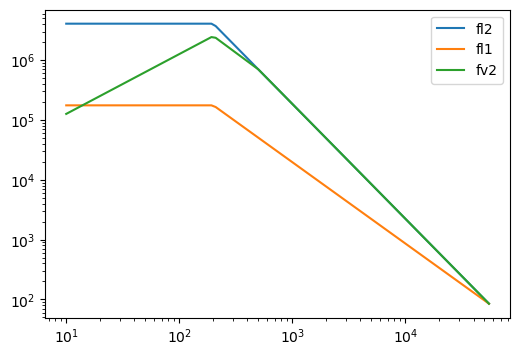

In [31]:
fig, ax = plt.subplots()
for Snu_arr, label in zip(Snu_arrs, labels):
    ax.plot(t_arr, Snu_arr, label=label)
ax.set(xscale='log', yscale='log')
ax.legend()
plt.show()

In [32]:
total = integrate.quad(lambda t: snr.Snu_t_fp(1000, t, tiop='2'), 0, snr.tn)[0]
print(total)

8976885404.239485


In [33]:
total = integrate.quad(lambda t: snr.Snu_t_fl(1000, t, tiop='2'), 0, snr.tn)[0]
print(total)

1693265821.8884728


In [34]:
ph0 = integrate.quad(lambda t: snr.Snu_t_fl(1000, t, tiop='2'), 0, snr.tMFA)[0]/total
ph1 = integrate.quad(lambda t: snr.Snu_t_fl(1000, t, tiop='2'), snr.tMFA, snr.tf)[0]/total
ph2 = integrate.quad(lambda t: snr.Snu_t_fl(1000, t, tiop='2'), snr.tf, snr.tn)[0]/total
print(ph0, ph1, ph2)

0.48059870018321815 0.2975414112312017 0.22185988859020658


### luminosity distribution

In [21]:
L_arr = np.array([4*np.pi*snr.Snu_t_fl(6300, 100, tiop='1')*(snr.d**2) for snr in snr_valid_SG_list])
L_arr *= 9.52141e19 # Jy kpc^2 --> erg/s/Hz

In [22]:
np.mean(np.log10(L_arr))

25.38539330965852

In [20]:
np.mean(np.log10(L_arr))

26.11967552331366

In [23]:
d_arr = np.log10(L_arr) - np.mean(np.log10(L_arr))
np.sqrt(np.dot(d_arr, d_arr)/len(d_arr))

0.942829160031233

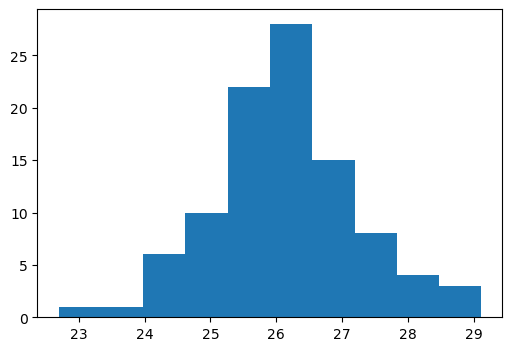

In [16]:
plt.hist(np.log10(L_arr))
plt.show()

In [84]:
snr = get_snr('W28', snr_valid_SG_list)
np.log10(4*np.pi*snr.Snu_t_fl(1000, 45, tiop='2')*(snr.d**2) * 9.52141e19)

28.407498699325583

In [85]:
snr = get_snr('Vela', snr_valid_SG_list)
np.log10(4*np.pi*snr.Snu_t_fl(1000, 300, tiop='2')*(snr.d**2) * 9.52141e19)

25.943674936926634

## Archive

## crude comparison to Vela

In [12]:
import scipy.integrate as integrate

In [13]:
def intSg(snr):
    tpower1 = -0.4*(snr.s+1)
    tpower2 = -0.8*snr.s
    def integrand(t):
        return (np.maximum(t, 100)/snr.tn)**tpower2
    return snr.flux1GHz * integrate.quad(integrand, 0, snr.tn)[0]

In [14]:
Vela = get_snr(GID(263.9,-3.3), snr_valid_wflux_list)
Vela.tf = 500
Vela.tn = 12000
tpw = -1.63
def integrand(t):
    return (np.maximum(t, Vela.tf)/Vela.tn)**tpw
intSg_Vela = Vela.flux1GHz * integrate.quad(integrand, 0, Vela.tn)[0]

In [20]:
c0kpcyr = 0.000306601 # kpc/yr
sigmad_over_c = 160/300000 # (km/s) / (km/s)
blur_sigma = 2*sigmad_over_c*(180/np.pi)*60 # arcmin
print(blur_sigma)

3.666929888837269


In [23]:
print('SNR GID      intSg   *bs^2   size   blur   dist   age      s    loc  other names')
for snr in snr_valid_wflux_list:
    m = intSg(snr)/intSg_Vela
    dDM_max = c0kpcyr * snr.tn/2 # kpc
    blur_max = (1+dDM_max/snr.d) * blur_sigma
    m2 = m*(blur_max/28.3)**-2
    if m > 1 or m2 > 1:
        print('%s  %.3f  %6.3f  %5.1f  %5.1f  %6.3f  %.1e  %.2f  %s   %s' % \
              (snr.ID, m, m2, snr.size, blur_max, snr.d, snr.tn, snr.s, snr.hemisph, snr.name[:40]))

SNR GID      intSg   *bs^2   size   blur   dist   age      s    loc  other names
G000.0+00.0  0.082   4.310    2.9    3.9   8.000  3.5e+03  2.60  S   Sgr A East
G006.4-00.1  19.931  81.511   48.0   14.0   1.876  3.4e+04  2.50  S   W28
G008.7-00.1  0.281   5.685   45.0    6.3   4.382  2.0e+04  2.00  S   (W30)
G018.8+00.3  1.023  13.662   14.0    7.7  13.794  1.0e+05  1.92  S   Kes 67
G021.8-00.6  0.086   3.305   20.0    4.6   5.596  9.0e+03  2.12  S   Kes 69
G023.3-00.3  3.658  10.752   27.0   16.5   4.796  1.1e+05  2.00  S   W41
G031.9+00.0  0.084   3.638    5.9    4.3   7.089  7.9e+03  2.50  S   3C391, Kes 77
G034.7-00.4  0.096   2.581   31.0    5.5   2.632  8.4e+03  1.74  N   W44, 3C392
G039.7-02.0  8.694  67.962   85.0   10.1   4.770  5.5e+04  2.40  N   W50, (SS433)
G049.2-00.7  0.117   3.143   30.0    5.5   5.367  1.7e+04  1.60  N   W51C
G054.4-00.3  0.571   3.771   40.0   11.0   4.667  6.1e+04  2.00  N   (HC40)
G065.1+00.6  0.432   5.159   67.0    8.2   9.295  7.5e+04  2.22  N   G

In [124]:
get_snr('G006.4-00.1', snr_list).spec_ind

0.75

In [126]:
get_snr('G039.7-02.0', snr_list).spec_ind

0.7